In [1]:
#!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True)

from jne_functions import *
from ipywidgets import interactive, FloatSlider
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, roc_curve,accuracy_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

In [3]:
df=pd.read_csv('bank_marketing_modified.csv')

In [4]:
X=df.loc[:,['campaign','previous','emp.var.rate','poutcome','euribor3m','nr.employed',
            'cons.price.idx','cons.conf.idx','employment','marital','education',
            'housing','loan','day_of_week','pdays_bin','age_group','default','month','contact','year']]
y=df['deposit']

In [5]:
X

,campaign,previous,emp.var.rate,poutcome,euribor3m,nr.employed,cons.price.idx,cons.conf.idx,employment,marital,education,housing,loan,day_of_week,pdays_bin,age_group,default,month,contact,year
0,1,0,1.1,nonexistent,4.857,5191.0,93.994,-36.4,employed,married,basic.4y,no,no,mon,0,Middle-aged,no,may,telephone,2008
1,1,0,1.1,nonexistent,4.857,5191.0,93.994,-36.4,employed,married,high.school,no,no,mon,0,Middle-aged,unknown,may,telephone,2008
2,1,0,1.1,nonexistent,4.857,5191.0,93.994,-36.4,employed,married,high.school,yes,no,mon,0,Adult,no,may,telephone,2008
3,1,0,1.1,nonexistent,4.857,5191.0,93.994,-36.4,employed,married,basic.6y,no,no,mon,0,Middle-aged,no,may,telephone,2008
4,1,0,1.1,nonexistent,4.857,5191.0,93.994,-36.4,employed,married,high.school,no,yes,mon,0,Middle-aged,no,may,telephone,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,1,0,-1.1,nonexistent,1.028,4963.6,94.767,-50.8,retired,married,professional.course,yes,no,fri,0,Senior,no,nov,cellular,2010
41172,1,0,-1.1,nonexistent,1.028,4963.6,94.767,-50.8,employed,married,professional.course,no,no,fri,0,Middle-aged,no,nov,cellular,2010
41173,2,0,-1.1,nonexistent,1.028,4963.6,94.767,-50.8,retired,married,university.degree,yes,no,fri,0,Middle-aged,no,nov,cellular,2010
41174,1,0,-1.1,nonexistent,1.028,4963.6,94.767,-50.8,employed,married,professional.course,no,no,fri,0,Middle-aged,no,nov,cellular,2010


In [6]:
n_fold=5
folds=StratifiedKFold(n_splits=n_fold,shuffle=True, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
cat_features=[3,8,9,10,11,12,13,14,15,16,17,18,19]
X_test=Pool(data=X_test, cat_features=cat_features)
scores=[]
prediction=np.zeros(X_test.shape[0])
for fold_n, (train_index, val_index) in enumerate(folds.split(X,y)):
    X_train,X_val=X.iloc[train_index],X.iloc[val_index]
    y_train, y_val=y[train_index],y[val_index]
    
    train_set=Pool(X_train,y_train,cat_features=cat_features)
    eval_ds=Pool(X_val,y_val,cat_features=cat_features)
    
    kitty_model= CatBoostClassifier(iterations=100,depth=5,
                                    learning_rate=0.5,
                                    loss_function='Logloss',
                                    class_weights=(1,10),
                                    eval_metric='AUC')
    kitty_model.fit(train_set,
                   eval_set=eval_ds,
                   use_best_model=True)
    score=kitty_model.get_best_score()
    scores.append(score)
    
    y_pred=kitty_model.predict_proba(X_test)[:,1]
    prediction += y_pred
prediction /=n_fold

0:	test: 0.7642348	best: 0.7642348 (0)	total: 71.5ms	remaining: 7.08s
1:	test: 0.7882430	best: 0.7882430 (1)	total: 85.7ms	remaining: 4.2s
2:	test: 0.8012796	best: 0.8012796 (2)	total: 102ms	remaining: 3.29s
3:	test: 0.8032396	best: 0.8032396 (3)	total: 119ms	remaining: 2.87s
4:	test: 0.8037133	best: 0.8037133 (4)	total: 138ms	remaining: 2.63s
5:	test: 0.8055603	best: 0.8055603 (5)	total: 157ms	remaining: 2.46s
6:	test: 0.8066330	best: 0.8066330 (6)	total: 177ms	remaining: 2.35s
7:	test: 0.8069123	best: 0.8069123 (7)	total: 195ms	remaining: 2.24s
8:	test: 0.8075673	best: 0.8075673 (8)	total: 210ms	remaining: 2.12s
9:	test: 0.8078411	best: 0.8078411 (9)	total: 221ms	remaining: 1.99s
10:	test: 0.8084176	best: 0.8084176 (10)	total: 236ms	remaining: 1.91s
11:	test: 0.8078716	best: 0.8084176 (10)	total: 253ms	remaining: 1.86s
12:	test: 0.8080086	best: 0.8084176 (10)	total: 265ms	remaining: 1.77s
13:	test: 0.8076813	best: 0.8084176 (10)	total: 283ms	remaining: 1.74s
14:	test: 0.8078761	best:

27:	test: 0.7933300	best: 0.7934579 (25)	total: 450ms	remaining: 1.16s
28:	test: 0.7960496	best: 0.7960496 (28)	total: 467ms	remaining: 1.14s
29:	test: 0.7982097	best: 0.7982097 (29)	total: 486ms	remaining: 1.13s
30:	test: 0.7986079	best: 0.7986079 (30)	total: 504ms	remaining: 1.12s
31:	test: 0.7992758	best: 0.7992758 (31)	total: 522ms	remaining: 1.11s
32:	test: 0.7988974	best: 0.7992758 (31)	total: 539ms	remaining: 1.09s
33:	test: 0.7988988	best: 0.7992758 (31)	total: 555ms	remaining: 1.08s
34:	test: 0.7992032	best: 0.7992758 (31)	total: 572ms	remaining: 1.06s
35:	test: 0.7994553	best: 0.7994553 (35)	total: 587ms	remaining: 1.04s
36:	test: 0.7994579	best: 0.7994579 (36)	total: 603ms	remaining: 1.03s
37:	test: 0.7988918	best: 0.7994579 (36)	total: 618ms	remaining: 1.01s
38:	test: 0.7988918	best: 0.7994579 (36)	total: 635ms	remaining: 994ms
39:	test: 0.7992586	best: 0.7994579 (36)	total: 653ms	remaining: 980ms
40:	test: 0.7980758	best: 0.7994579 (36)	total: 670ms	remaining: 964ms
41:	te

53:	test: 0.8062533	best: 0.8072967 (29)	total: 898ms	remaining: 765ms
54:	test: 0.8066649	best: 0.8072967 (29)	total: 914ms	remaining: 748ms
55:	test: 0.8058832	best: 0.8072967 (29)	total: 932ms	remaining: 732ms
56:	test: 0.8059037	best: 0.8072967 (29)	total: 956ms	remaining: 721ms
57:	test: 0.8059711	best: 0.8072967 (29)	total: 975ms	remaining: 706ms
58:	test: 0.8059711	best: 0.8072967 (29)	total: 992ms	remaining: 689ms
59:	test: 0.8059711	best: 0.8072967 (29)	total: 1.01s	remaining: 673ms
60:	test: 0.8048101	best: 0.8072967 (29)	total: 1.02s	remaining: 656ms
61:	test: 0.8049359	best: 0.8072967 (29)	total: 1.04s	remaining: 638ms
62:	test: 0.8050912	best: 0.8072967 (29)	total: 1.06s	remaining: 620ms
63:	test: 0.8053195	best: 0.8072967 (29)	total: 1.07s	remaining: 603ms
64:	test: 0.8053535	best: 0.8072967 (29)	total: 1.09s	remaining: 585ms
65:	test: 0.8057347	best: 0.8072967 (29)	total: 1.1s	remaining: 569ms
66:	test: 0.8065604	best: 0.8072967 (29)	total: 1.12s	remaining: 553ms
67:	tes

73:	test: 0.7934857	best: 0.7983450 (30)	total: 1.28s	remaining: 449ms
74:	test: 0.7934031	best: 0.7983450 (30)	total: 1.3s	remaining: 433ms
75:	test: 0.7934246	best: 0.7983450 (30)	total: 1.32s	remaining: 417ms
76:	test: 0.7934056	best: 0.7983450 (30)	total: 1.34s	remaining: 400ms
77:	test: 0.7929651	best: 0.7983450 (30)	total: 1.36s	remaining: 383ms
78:	test: 0.7929138	best: 0.7983450 (30)	total: 1.38s	remaining: 367ms
79:	test: 0.7930445	best: 0.7983450 (30)	total: 1.4s	remaining: 350ms
80:	test: 0.7930445	best: 0.7983450 (30)	total: 1.42s	remaining: 333ms
81:	test: 0.7920509	best: 0.7983450 (30)	total: 1.44s	remaining: 316ms
82:	test: 0.7917957	best: 0.7983450 (30)	total: 1.46s	remaining: 299ms
83:	test: 0.7914299	best: 0.7983450 (30)	total: 1.48s	remaining: 281ms
84:	test: 0.7912481	best: 0.7983450 (30)	total: 1.5s	remaining: 265ms
85:	test: 0.7908389	best: 0.7983450 (30)	total: 1.52s	remaining: 247ms
86:	test: 0.7908899	best: 0.7983450 (30)	total: 1.53s	remaining: 229ms
87:	test:

98:	test: 0.7991246	best: 0.8014876 (51)	total: 1.71s	remaining: 17.2ms
99:	test: 0.7992775	best: 0.8014876 (51)	total: 1.73s	remaining: 0us

bestTest = 0.801487591
bestIteration = 51

Shrink model to first 52 iterations.


In [7]:
confusion_matrix(y_test, kitty_model.predict(X_test))

array([[5996, 1312],
       [ 283,  645]])

In [8]:
def make_confusion_matrix(model, threshold=0.5):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    deposit_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    group_counts=['{0:0.0f}'.format(value) for value in deposit_confusion.flatten()]
    group_perc=['{0:.2%}'.format(value) for value in deposit_confusion.flatten()/np.sum(deposit_confusion)]
    labels=[f'{v1}\n{v2}' for v1,v2 in zip(group_counts,group_perc)]
    labels=np.asarray(labels).reshape(2,2)
    sns.heatmap(deposit_confusion, cmap=plt.cm.Blues, annot=labels, square=True, fmt='',
                xticklabels=['No', 'Yes'],
                yticklabels=['No', 'Yes']);
    plt.xlabel('Prediction').set_color('black')
    plt.ylabel('Actual').set_color('black')
    plt.title ('Catboost Confusion matrix')
    plt.tick_params(colors='black')

In [9]:
interactive(lambda threshold: make_confusion_matrix(kitty_model, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

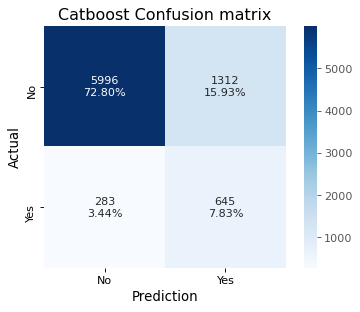

In [10]:
make_confusion_matrix(kitty_model,0.50)
plt.savefig('catboost_confusion_matrix.svg',format='svg');

In [11]:
#Looking at difference between actual and predicted 
y_predict = kitty_model.predict(X_test)
print('True',y_test.values[0:30])
print('Pred', y_predict[0:30])

True [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Pred [0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


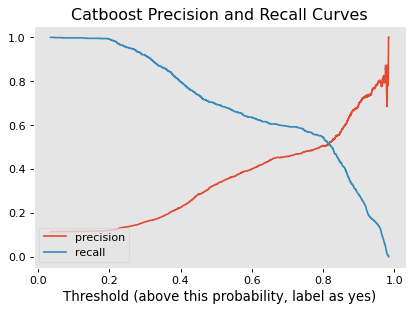

In [12]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, kitty_model.predict_proba(X_test)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as yes)').set_color('black')
plt.tick_params(colors='black')
plt.grid(b=None)
plt.title('Catboost Precision and Recall Curves')
plt.savefig('Catboost_prcurve.svg',format='svg');

In [13]:
y_predict = kitty_model.predict(X_test)
f1_score(y_test, y_predict,average='macro')

0.6648743784678468

In [14]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      7308
           1       0.33      0.70      0.45       928

    accuracy                           0.81      8236
   macro avg       0.64      0.76      0.66      8236
weighted avg       0.88      0.81      0.83      8236



In [15]:
y_predict = (kitty_model.predict_proba(X_test)[:, 1] > 0.8)
f1_score(y_test, y_predict, average='macro')

0.7305425265219352

In [16]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      7308
           1       0.51      0.54      0.52       928

    accuracy                           0.89      8236
   macro avg       0.72      0.74      0.73      8236
weighted avg       0.89      0.89      0.89      8236



In [17]:
cat_fpr, cat_tpr, thresholds = roc_curve(y_test, kitty_model.predict_proba(X_test)[:,1])

0.8222071967659438

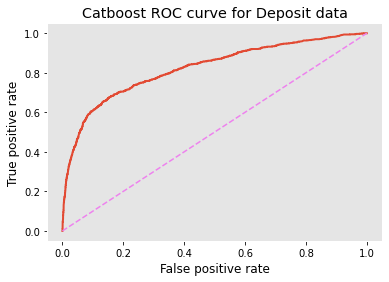

In [18]:
plt.plot(cat_fpr, cat_tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate').set_color('black')
plt.ylabel('True positive rate').set_color('black')
plt.tick_params(colors='black')
plt.grid(b=None)
plt.title('Catboost ROC curve for Deposit data')
plt.savefig('CatboostROC.svg',format='svg');
LOG_AUC=roc_auc_score(y_test, kitty_model.predict_proba(X_test)[:,1])
LOG_AUC

In [19]:
confusion=confusion_matrix(y_test, kitty_model.predict(X_test))
TP=confusion[1,1]
TN=confusion[0,0]
FP=confusion[0,1]
FN=confusion[1,0]
(TP+TN)/float(TP+TN+FP+FN)
accuracy_score(y_test,y_predict)

0.8886595434677028

In [20]:
#Misclassification rate/Clasification Error
1-accuracy_score(y_test,y_predict)

0.11134045653229718

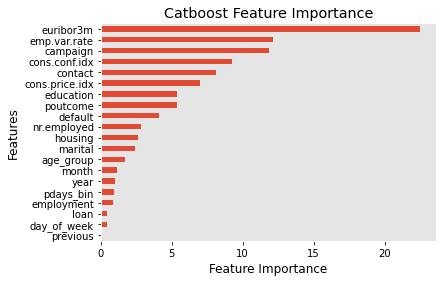

In [21]:
feat_importances=pd.Series(kitty_model.feature_importances_,index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title('Catboost Feature Importance')
plt.tick_params(colors='black')
plt.grid(b=None)
plt.ylabel('Features').set_color('black')
plt.xlabel('Feature Importance').set_color('black')
plt.savefig('catboost_feature_importance.svg',format='svg');

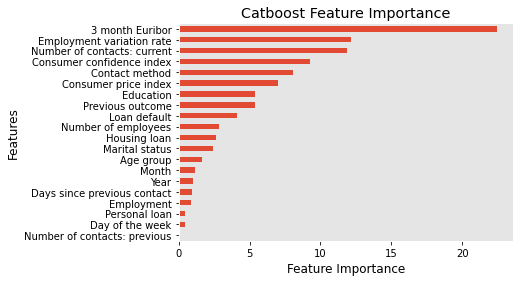

In [22]:
#relabeling for clarification
feat_importances=pd.Series(kitty_model.feature_importances_,index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title('Catboost Feature Importance')
plt.tick_params(colors='black')
plt.grid(b=None)

y=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
labels=['Number of contacts: previous','Day of the week','Personal loan','Employment','Days since previous contact',
       'Year','Month','Age group','Marital status','Housing loan','Number of employees',
       'Loan default','Previous outcome','Education','Consumer price index','Contact method',
       'Consumer confidence index','Number of contacts: current','Employment variation rate',
       '3 month Euribor']
plt.yticks(y,labels)
plt.ylabel('Features').set_color('black')
plt.xlabel('Feature Importance').set_color('black')
plt.savefig('catboost_feature_importance_modified.svg',format='svg');

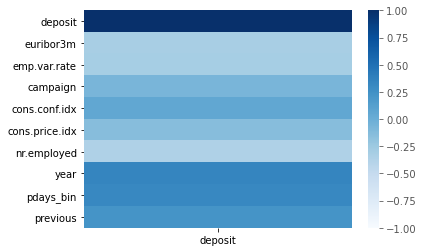

In [26]:
df1=df.loc[:,['deposit','euribor3m','emp.var.rate','campaign','cons.conf.idx','contact',
             'cons.price.idx','education','poutcome','default','nr.employed','housing','marital',
             'age_group','month','year','pdays_bin','employment','loan','day_of_week','previous']]
sns.heatmap(df1.corr()[['deposit']],vmin=-1,vmax=1,annot=False, cmap=plt.cm.Blues)
plt.tick_params(colors='black');
plt.savefig('deposit_correlation.svg',bbox_inches='tight',format='svg')

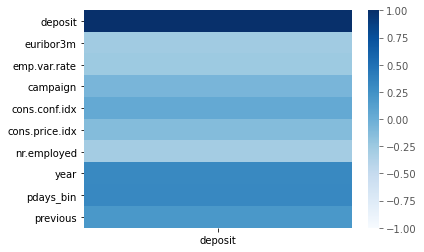

In [24]:
sns.heatmap(df1.corr(method='spearman')[['deposit']],vmin=-1,vmax=1,
            annot=False, cmap=plt.cm.Blues)
plt.tick_params(colors='black');

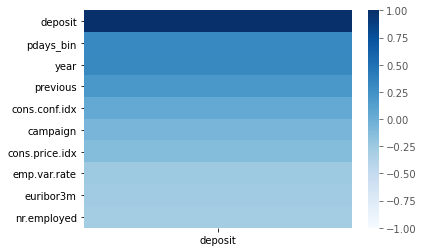

In [25]:
sns.heatmap(df1.corr(method='spearman')[['deposit']].sort_values(by='deposit',ascending=False),vmin=-1,vmax=1,
            annot=False, cmap=plt.cm.Blues)
plt.tick_params(colors='black');